In [1]:
"""Plot domain mask with develop environment version"""
import os
import PIL.Image
import numpy as np

def create_domain_mask_develop_png():
    domain_mask_png = "/home/HYDROAPP/develop/wh3248/h4/domain_files/domain_mask.png"
    if not os.path.exists(domain_mask_png):
        raise ValueError(f"{domain_mask_png} does not exist")
    pdata = PIL.Image.open(domain_mask_png)
    ndata = np.array(pdata)
    ndata = np.flip(ndata, 0)
    print(ndata.shape)
    ndata = np.where(ndata == 1, 0, 0xFFFF)
    ndata = ndata.astype(np.uint16)
    img = PIL.Image.fromarray(ndata)
    img = img.resize((ndata.shape[0]*10, ndata.shape[1]*10), PIL.Image.NEAREST)
    return img



In [2]:
"""Plot domain mask with main environment version"""
import os
import PIL.Image
import numpy as np
def create_domain_mask_main_png():
    domain_mask_png = "/home/HYDROAPP/main/wh3248/h4/domain_files/domain_mask.png"
    if not os.path.exists(domain_mask_png):
        raise ValueError(f"{domain_mask_png} does not exist")
    pdata = PIL.Image.open(domain_mask_png)
    ndata = np.array(pdata)
    ndata = np.flip(ndata, 0)
    print(ndata.shape)
    ndata = np.where(ndata == 1, 0, 0xFFFF)
    ndata = ndata.astype(np.uint16)
    img = PIL.Image.fromarray(ndata)
    img = img.resize((260, 230), PIL.Image.NEAREST)
    return img


In [3]:
import os
import json

def get_domain_xy_bounds():
    """Return (x_bounds, y_bounds) of domain in X,Y (esri:102004) coordinate space
    The x_bounds [x_low, x_high] and y_bounds = [y_low, y_high].
    For example, x_low is the left most x point in meters (not K meters)
    using the esri:102004 world center point
    """

    domain_state_path = "/home/HYDROAPP/develop/wh3248/h4/domain_state.json"
    if not os.path.exists(domain_state_path):
        raise ValueError(f"{domain_state_path} does not exist.")
    domain_state = {}
    with open(domain_state_path) as stream:
        contents = stream.read()
        domain_state = json.loads(contents)
    grid_bounds = domain_state.get("grid_bounds", None)
    if not grid_bounds:
        raise ValueError("No grid_bounds found of the domain")
    # x,y bbox from CONUS1 shapefile in X,Y (esri:102004) coordinate space
    conus_x_bounds = [-1884563.7545318902, 1457436.245467998]
    conus_y_bounds = [-605655.0023756996, 1282344.9976419993]
    x_bounds = [
        conus_x_bounds[0] + grid_bounds[0] * 1000,
        conus_x_bounds[0] + grid_bounds[2] * 1000,
    ]
    y_bounds = [
        conus_y_bounds[0] + grid_bounds[1] * 1000,
        conus_y_bounds[0] + grid_bounds[3] * 1000,
    ]
    return (x_bounds, y_bounds)


get_domain_xy_bounds()


([-1591563.7545318902, -1568563.7545318902],
 [333344.9976243004, 359344.9976243004])

In [4]:
"""Create heatmap projection png of domain soil moisture forecast"""
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def create_sm_forecast_png(coord_system="epsg:4326"):
    sm_path = "/home/HYDROAPP/develop/wh3248/h4/forecast/1/forecast.2023-03-17_2023-06-14.nc"
    if not os.path.exists(sm_path):
        raise ValueError(f"{sm_path} does not exist.")
    ds = xr.open_dataset(sm_path)
    data_array = ds["soil_moisture"]

    domain_mask_path = "/home/HYDROAPP/develop/wh3248/h4/domain_files/domain_mask.png"
    if not os.path.exists(domain_mask_path):
        raise ValueError(f"{domain_mask_path} does not exist")
    img = PIL.Image.open(domain_mask_path)
    domain_mask = np.array(img)
    cmap = plt.colormaps.get("viridis")
    color_map = (np.array([cmap(v)[0:3] for v in range(0, cmap.N)]) * 255).astype(np.uint8)
    data_array = data_array.isel(time=0)
    data_array = data_array.isel(z=4)
    data_array = data_array.isel(member=0)
    data_np = data_array.to_numpy().astype(int)
    data_df = (pd.DataFrame(data_np).stack().rename_axis(["y", "x"]).reset_index(name="val"))
    cmap_df = pd.DataFrame(color_map, columns=["red", "green", "blue"], dtype=int)
    cmap_df["val"] = np.arange(color_map.shape[0])
    mapped_df = data_df.join(cmap_df, on="val", how="left", rsuffix="val")
    red_numpy = np.reshape(
        mapped_df["red"].to_numpy().astype(np.uint8), data_array.shape
    )
    green_numpy = np.reshape(
        mapped_df["green"].to_numpy().astype(np.uint8), data_array.shape
    )
    blue_numpy = np.reshape(
        mapped_df["blue"].to_numpy().astype(np.uint8), data_array.shape
    )

    red_numpy[domain_mask == 0] = 0xFFFF
    green_numpy[domain_mask == 0] = 0xFFFF
    blue_numpy[domain_mask == 0] = 0xFFFF
    xds = xr.Dataset(
        data_vars=dict(
            R=(["y", "x"], red_numpy),
            G=(["y", "x"], green_numpy),
            B=(["y", "x"], blue_numpy),
        )
    )
    (x_bounds, y_bounds) = get_domain_xy_bounds()
    xcoord = np.linspace(x_bounds[0], x_bounds[1], num=len(xds["x"]))
    ycoord = np.linspace(y_bounds[0], y_bounds[1], num=len(xds["y"]))

    # Assign the esri:102004 coordindates to the xarray dataset
    xds = xds.assign_coords({"x": xcoord, "y": ycoord})
    xds = xds.rio.write_crs("esri:102004")
    xds = xds.rio.write_coordinate_system()

    # project to the lat/lng (epsg:3857) coordindate space
    xds = xds.rio.reproject(coord_system)

    # Convert it to a raster file as a .png
    png_path = "/home/wh3248/tmp/foo.png"
    xds.rio.to_raster(png_path)
    img = PIL.Image.open(png_path)
    print(img.size)
    img = img.resize((data_np.shape[0]*10, data_np.shape[1]*10), PIL.Image.NEAREST)
    img.save(png_path, transparent=True)
    return png_path
    
create_sm_forecast_png()
        

(30, 25)


'/home/wh3248/tmp/foo.png'

(26, 23)


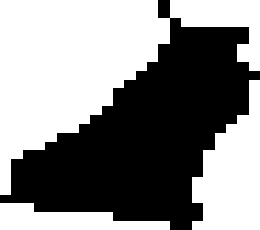

(30, 25)


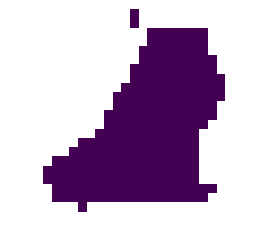

(28, 26)


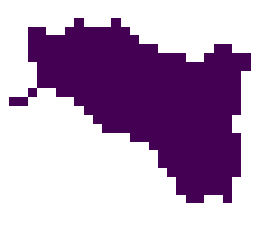

In [5]:
from IPython.display import Image, display
img = create_domain_mask_develop_png()
img.show()
png_path = create_sm_forecast_png()
display(Image(filename=png_path))
png_path = create_sm_forecast_png("epsg:3248")
display(Image(filename=png_path))


In [6]:
"""Experiment with pyproj to do projections"""
import pyproj

crs_4269 = pyproj.CRS.from_epsg(4269)
crs_9001 = pyproj.CRS.from_epsg(9001)
crs_4326 = pyproj.CRS.from_epsg(4326)
transformer_to_4326 = pyproj.Transformer.from_crs("ESRI:102004", "EPSG:4326")
transformer_from_4326 = pyproj.Transformer.from_crs("EPSG:4326", "ESRI:102004")
conus_x_bounds = [-1884563.7545318902, 1457436.245467998]
conus_y_bounds = [-605655.0023756996, 1282344.9976419993]
conus_x_bounds =  [-1885055.4994999999180436,1456944.5005000000819564]
conus_y_bounds =  [-604957.0653999999631196,1283042.9346000000368804]    


[x1, y1] = transformer_from_4326.transform(40.5088, -115.019)
print([x1, y1])
[x, y] = transformer_to_4326.transform(x1, y1)
print([x, y])
[x2, y2] = transformer_from_4326.transform(40.782, -114.816)
print([x1, y1])
print([(x1 - conus_x_bounds[0])/1000, (y1 - conus_y_bounds[0])/1000])
print([(x2 - conus_x_bounds[0])/1000, (y2 - conus_y_bounds[0])/1000])
print((x2 - x1)/1000)
print((y2 - y1)/1000)
for i in range(0, 300):
    for j in range(0, 300):
        transformer_to_4326.transform(i, j)


[-1591998.9001055888, 333828.5199070535]
[40.50880000000001, -115.019]
[-1591998.9001055888, 333828.5199070535]
[293.0565993944111, 938.7855853070536]
[316.00912361245764, 964.7869150209774]
22.952524218046573
26.001329713923973


In [7]:
"""Conversion functions between lat/lon to CONUS1 x/y"""

import pyproj

def convert_to_wgs84(point):
    """Convert a point [x, y] in Conus1 to [lat,lon]"""
    transformer = pyproj.Transformer.from_crs("ESRI:102004", "EPSG:4326")
    x_origin = -1885055.4994999999180436
    y_origin = -604957.0653999999631196
    result1 = transformer.transform(point[0]*1000 + x_origin, point[1]*1000 + y_origin)
    result = [result1[0], result1[1]]
    return result

def convert_from_wgs84(lat_lon):
    """Convert a point [lat, lon] to [x, y]"""
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "ESRI:102004")
    x_origin = -1885055.4994999999180436
    y_origin = -604957.0653999999631196
    point = transformer.transform(lat_lon[0], lat_lon[1])
    result = [int((point[0]-x_origin)/1000 + 0.5), int((point[1]-y_origin)/1000 + 0.5)]
    return result

lat_lon = convert_from_wgs84([40.5088, -115.019])
print(lat_lon)
assert lat_lon[0] == 293
assert lat_lon[1] == 939
point = convert_to_wgs84(lat_lon)
assert round(point[0], 1) == 40.5
assert round(point[1], 1) == -115.0
    

[293, 939]


In [8]:
from hydrodata.national_mapping.map_wgs84 import ConusMap

map = ConusMap("conus1")
for x in range(0, 3000, 400):
    for y in range(0, 1880, 400):
        latlon_hd = map.map_from_grid(x, y)
        point_hd = map.map_to_grid(latlon_hd[0], latlon_hd[1])
        assert point_hd[0] == x
        assert point_hd[1] == y
        latlon_func = convert_to_wgs84([x, y])
        point_func = convert_from_wgs84(latlon_func)
        point_func2 = convert_from_wgs84([latlon_hd[1], latlon_hd[0]])
        print(x)
        print(y)
        print(point_hd)
        print(point_func)
        print(point_func2)
        assert point_func[0] == x
        assert point_func[1] == y
        assert abs(point_func[0] - point_func2[0]) <= 1
        assert abs(point_func[1] - point_func2[1]) <= 1


0
0
(0, 0)
[0, 0]
[1, 0]
0
400
(0, 400)
[0, 400]
[1, 400]
0
800
(0, 800)
[0, 800]
[1, 800]
0
1200
(0, 1200)
[0, 1200]
[1, 1200]
0
1600
(0, 1600)
[0, 1600]
[1, 1600]
400
0
(400, 0)
[400, 0]
[401, 0]
400
400
(400, 400)
[400, 400]
[401, 400]
400
800
(400, 800)
[400, 800]
[401, 800]
400
1200
(400, 1200)
[400, 1200]
[401, 1200]
400
1600
(400, 1600)
[400, 1600]
[401, 1600]
800
0
(800, 0)
[800, 0]
[801, 0]
800
400
(800, 400)
[800, 400]
[801, 400]
800
800
(800, 800)
[800, 800]
[801, 800]
800
1200
(800, 1200)
[800, 1200]
[801, 1200]
800
1600
(800, 1600)
[800, 1600]
[801, 1600]
1200
0
(1200, 0)
[1200, 0]
[1201, 0]
1200
400
(1200, 400)
[1200, 400]
[1201, 400]
1200
800
(1200, 800)
[1200, 800]
[1201, 800]
1200
1200
(1200, 1200)
[1200, 1200]
[1201, 1200]
1200
1600
(1200, 1600)
[1200, 1600]
[1201, 1600]
1600
0
(1600, 0)
[1600, 0]
[1601, 0]
1600
400
(1600, 400)
[1600, 400]
[1601, 400]
1600
800
(1600, 800)
[1600, 800]
[1601, 800]
1600
1200
(1600, 1200)
[1600, 1200]
[1601, 1200]
1600
1600
(1600, 1600)
[

In [19]:
"""Performance test lat/lon mapping"""

import time
start_time = time.time()
for x in range(0, 3000, 100):
    for y in range(0, 1880, 100):
        latlon_func = convert_to_wgs84([x, y])
        point_func = convert_from_wgs84(latlon_func)
        assert point_func[0] == x
        assert point_func[1] == y
duration = round((time.time() - start_time), 2)
print(duration)


15.45


In [29]:
"""Performance test lat/lon mapping"""

import time
start_time = time.time()
latlon_list = []
for x in range(0, 3000, 100):
    for y in range(0, 1880, 100):
        latlon = convert_to_wgs84([x, y])
        latlon_list.append(latlon)
duration = round((time.time() - start_time), 2)
# 570 points / 6.4 seconds = 85.4 points/seconds
print(duration)
print(len(latlon_list))
print(len(latlon_list)/duration)

start_time = time.time()
point_list = []
for i in range(0, len(latlon_list)):
    point = convert_from_wgs84(latlon_list[i])
    point_list.append(point)
duration = round((time.time() - start_time), 2)
# 570 points / 8.72 seconds = 65.36 points/sec
print(duration)
print(len(point_list))
points_per_sec = len(point_list)/duration
print(f"{points_per_sec} points per second")

conus1_hours = 3256 * 1888/(points_per_sec * 60 * 60)
print(f"{conus1_hours} hours per conus 1")
# 26 hours per conus 1

6.7
570
85.07462686567163
8.72
570
65.36697247706421 points per second
26.12314822612086 hours per conus 1
